# Global Air Pollution

This dataset contains air quality index from various cities around the world, including overall Air Quality Index (AQI) values and Air Quality Index values for specific pollutants such as CO, Ozone, NO2, and PM2.5.


# Import Libraries

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 10.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from geopy.geocoders import Nominatim
import geopandas as gpd
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import folium
from folium import plugins
import time
import shap

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#1.&nbsp;Load Dataset

In [ ]:
# Load dataset via Gdrive
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone Project/global air pollution dataset.csv")
df.head()

Country              City  AQI Value AQI Category  CO AQI Value  \
0  Russian Federation        Praskoveya         51     Moderate             1   
1              Brazil  Presidente Dutra         41         Good             1   
2               Italy   Priolo Gargallo         66     Moderate             1   
3              Poland         Przasnysz         34         Good             1   
4              France          Punaauia         22         Good             0   

  CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
0            Good               36               Good              0   
1            Good                5               Good              1   
2            Good               39               Good              2   
3            Good               34               Good              0   
4            Good               22               Good              0   

  NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category  
0             Good               51           Moderate  
1             Good               41               Good  
2             Good               66           Moderate  
3             Good               20               Good  
4             Good                6               Good

## 1.1&nbsp;Feature Description
1. Country: Nama Negara
2. City: Nama Kota
3. AQI Value: Nilai AQI Kota
4. AQI Category: Kategori AQI Kota
5. CO AQI Value: Nilai AQI Karbon Monoksida Kota
6. CO AQI Category: Kategori AQI Karbon Monoksida Kota
7. Ozone AQI Value: Nilai AQI Ozon Kota
8. Ozone AQI Category: Kategori AQI Ozon Kota
9. NO2 AQI Value: Nilai AQI Nitrogen Dioksida Kota
10. NO2 AQI Category: Kategori AQI Nitrogen Dioksida Kota
11. PM2.5 AQI Value: Nilai AQI PM2.5 Kota
12. PM2.5 AQI Category: Kategori AQI PM2.5 Kota


* CO AQI Value

  Konsentrasi karbon monoksida (CO) dapat berasal dari sumber-sumber seperti kendaraan bermotor, pembakaran bahan bakar fosil, dan industri. Tingkat CO yang tinggi dapat menandakan polusi udara yang disebabkan oleh kendaraan dan kegiatan industri di sekitar area.
* Ozone AQI Value

  Tingkat ozon yang tinggi dapat disebabkan oleh reaksi kimia antara oksida nitrogen (NOx) dan senyawa organik yang menguap dalam sinar matahari. Aktivitas manusia seperti lalu lintas kendaraan dan industri dapat menjadi penyumbang utama terhadap pembentukan ozon yang tinggi.
* NO2 AQI Value

  Oksida nitrogen (NO2) adalah gas pencemar yang berasal dari pembakaran bahan bakar fosil, terutama dari kendaraan bermotor dan pembangkit listrik. Tingkat NO2 yang tinggi dapat menunjukkan polusi udara yang disebabkan oleh transportasi dan kegiatan industri.
* PM2.5

  Partikulat matter (PM2.5) adalah partikel kecil dalam udara yang dapat masuk ke dalam saluran pernapasan manusia. Partikel ini berasal dari berbagai sumber termasuk kendaraan bermotor, industri, pembakaran biomassa, dan aktivitas konstruksi. Tingkat PM2.5 yang tinggi dapat menunjukkan polusi udara dari berbagai sumber tersebut.

#2.&nbsp;Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country             23036 non-null  object
 1   City                23462 non-null  object
 2   AQI Value           23463 non-null  int64 
 3   AQI Category        23463 non-null  object
 4   CO AQI Value        23463 non-null  int64 
 5   CO AQI Category     23463 non-null  object
 6   Ozone AQI Value     23463 non-null  int64 
 7   Ozone AQI Category  23463 non-null  object
 8   NO2 AQI Value       23463 non-null  int64 
 9   NO2 AQI Category    23463 non-null  object
 10  PM2.5 AQI Value     23463 non-null  int64 
 11  PM2.5 AQI Category  23463 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.1+ MB


In [ ]:
# Let see data dimension
df.shape

(23463, 12)

In [ ]:
# Missing Value of whole dataset
df.isnull().sum()

Country               427
City                    1
AQI Value               0
AQI Category            0
CO AQI Value            0
CO AQI Category         0
Ozone AQI Value         0
Ozone AQI Category      0
NO2 AQI Value           0
NO2 AQI Category        0
PM2.5 AQI Value         0
PM2.5 AQI Category      0
dtype: int64

Text(0.5, 0, '\nPersentase Missing Value')

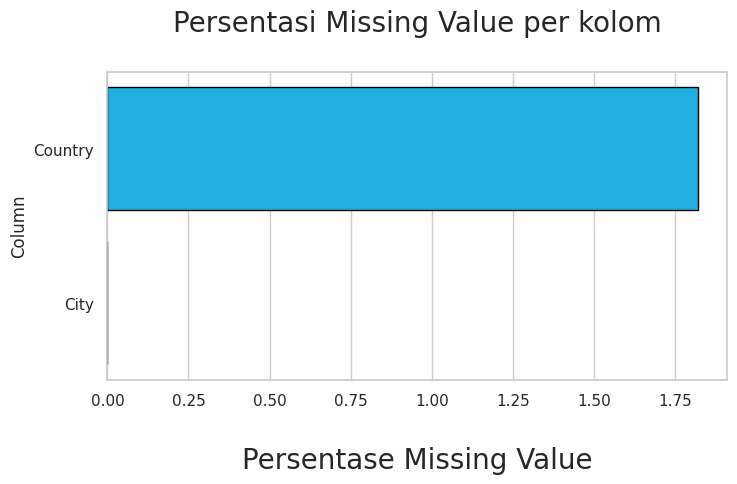

In [ ]:
# Check the NaN by ploting percent of missing values per column
column_with_nan = df.columns[df.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(round(df[i].isnull().sum()*100/len(df), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(
    x="Percent_NaN",
    y="Column",
    data=tab,
    edgecolor="black",
    color="deepskyblue"
)

p.set_title("Persentasi Missing Value per kolom\n", fontsize=20)
p.set_xlabel("\nPersentase Missing Value", fontsize=20)

In [ ]:
# Data Statistics Description
df.describe()

AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  \
count  23463.000000  23463.000000     23463.000000   23463.000000   
mean      72.010868      1.368367        35.193709       3.063334   
std       56.055220      1.832064        28.098723       5.254108   
min        6.000000      0.000000         0.000000       0.000000   
25%       39.000000      1.000000        21.000000       0.000000   
50%       55.000000      1.000000        31.000000       1.000000   
75%       79.000000      1.000000        40.000000       4.000000   
max      500.000000    133.000000       235.000000      91.000000   

       PM2.5 AQI Value  
count     23463.000000  
mean         68.519755  
std          54.796443  
min           0.000000  
25%          35.000000  
50%          54.000000  
75%          79.000000  
max         500.000000

In [ ]:
df.describe(include=['object'])

Country        City AQI Category CO AQI Category  \
count                      23036       23462        23463           23463   
unique                       175       23462            6               3   
top     United States of America  Praskoveya         Good            Good   
freq                        2872           1         9936           23460   

       Ozone AQI Category NO2 AQI Category PM2.5 AQI Category  
count               23463            23463              23463  
unique                  5                2                  6  
top                  Good             Good               Good  
freq                21069            23448              10208

In [ ]:
# Checking the Unique Value
df.nunique()

Country                 175
City                  23462
AQI Value               347
AQI Category              6
CO AQI Value             34
CO AQI Category           3
Ozone AQI Value         213
Ozone AQI Category        5
NO2 AQI Value            59
NO2 AQI Category          2
PM2.5 AQI Value         383
PM2.5 AQI Category        6
dtype: int64

We focused in ASEAN countries, so we filtering the data so we got all ASEAN countries dataframe

In [ ]:
asean_countries = ["Brunei", "Cambodia", "Indonesia", "Laos", "Malaysia", "Myanmar", "Philippines", "Singapore", "Thailand", "Vietnam"]

df_asean = df[df['Country'].isin(asean_countries)]
df_asean

Country                 City  AQI Value AQI Category  CO AQI Value  \
31       Indonesia            Pontianak         44         Good             1   
55     Philippines              Dipolog         30         Good             1   
66     Philippines               Guiset         66     Moderate             1   
96       Indonesia               Tidore         21         Good             0   
99     Philippines               Toboso         54     Moderate             1   
...            ...                  ...        ...          ...           ...   
23392      Myanmar              Paungde         33         Good             1   
23415     Thailand  Nakhon Si Thammarat         58     Moderate             1   
23424    Indonesia            Kabanjahe         22         Good             0   
23437  Philippines               Teresa         65     Moderate             1   
23462     Malaysia               Marang         70     Moderate             1   

      CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
31               Good               15               Good              0   
55               Good               17               Good              0   
66               Good               26               Good              1   
96               Good               13               Good              0   
99               Good               20               Good              0   
...               ...              ...                ...            ...   
23392            Good               17               Good              0   
23415            Good               32               Good              0   
23424            Good               18               Good              0   
23437            Good               25               Good              2   
23462            Good               38               Good              0   

      NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category  
31                Good               44               Good  
55                Good               30               Good  
66                Good               66           Moderate  
96                Good               21               Good  
99                Good               54           Moderate  
...                ...              ...                ...  
23392             Good               33               Good  
23415             Good               58           Moderate  
23424             Good               22               Good  
23437             Good               65           Moderate  
23462             Good               70           Moderate  

[1159 rows x 12 columns]

In [ ]:
df_asean['Country'].value_counts()

Country
Indonesia      379
Philippines    337
Thailand       246
Malaysia       125
Myanmar         59
Cambodia        12
Singapore        1
Name: count, dtype: int64

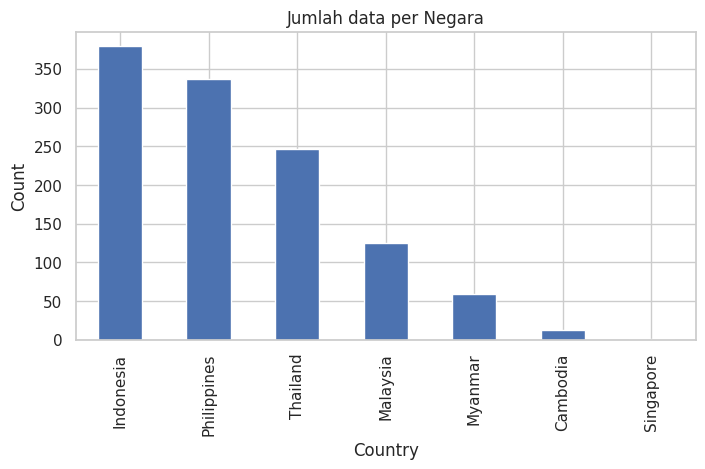

In [ ]:
df_asean['Country'].value_counts().plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Jumlah data per Negara')
plt.show()


In [ ]:
# Get sample of each countries
def sample_per_country(group):
    return group.sample(n=1)

df_sampled = df_asean.groupby('Country').apply(sample_per_country).reset_index(drop=True)
df_sampled

Country          City  AQI Value AQI Category  CO AQI Value  \
0     Cambodia        Pousat         26         Good             0   
1    Indonesia         Diwek        154    Unhealthy             3   
2     Malaysia       Kuantan         86     Moderate             1   
3      Myanmar  Moulmeingyun         34         Good             0   
4  Philippines      Calbayog         36         Good             1   
5    Singapore     Singapore         91     Moderate             1   
6     Thailand     Nam Phong         86     Moderate             2   

  CO AQI Category  Ozone AQI Value              Ozone AQI Category  \
0            Good               18                            Good   
1            Good              126  Unhealthy for Sensitive Groups   
2            Good               38                            Good   
3            Good               24                            Good   
4            Good               22                            Good   
5            Good               29                            Good   
6            Good               21                            Good   

   NO2 AQI Value NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category  
0              0             Good               26               Good  
1              2             Good              154          Unhealthy  
2              0             Good               86           Moderate  
3              0             Good               34               Good  
4              0             Good               36               Good  
5              4             Good               91           Moderate  
6              4             Good               86           Moderate

In [ ]:
df_asean['Country'].value_counts()

Country
Indonesia      379
Philippines    337
Thailand       246
Malaysia       125
Myanmar         59
Cambodia        12
Singapore        1
Name: count, dtype: int64

In [ ]:
df_asean.head()

Country       City  AQI Value AQI Category  CO AQI Value  \
31    Indonesia  Pontianak         44         Good             1   
55  Philippines    Dipolog         30         Good             1   
66  Philippines     Guiset         66     Moderate             1   
96    Indonesia     Tidore         21         Good             0   
99  Philippines     Toboso         54     Moderate             1   

   CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
31            Good               15               Good              0   
55            Good               17               Good              0   
66            Good               26               Good              1   
96            Good               13               Good              0   
99            Good               20               Good              0   

   NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category  
31             Good               44               Good  
55             Good               30               Good  
66             Good               66           Moderate  
96             Good               21               Good  
99             Good               54           Moderate

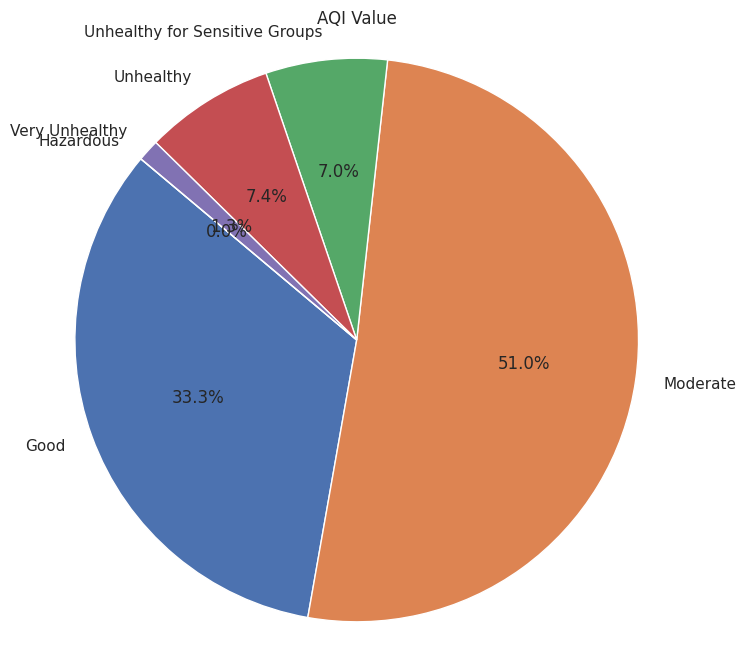

In [ ]:
# Pie Chart of AQI Values
df_one = df_asean[df_asean['AQI Value'] <= 50]
df_two = df_asean[(df_asean['AQI Value'] > 51) & (df_asean['AQI Value'] <= 100)]
df_three = df_med = df_asean[(df_asean['AQI Value'] > 101) & (df_asean['AQI Value'] <= 150)]
df_four = df_med = df_asean[(df_asean['AQI Value'] > 151) & (df_asean['AQI Value'] <= 200)]
df_five = df_med = df_asean[(df_asean['AQI Value'] > 201) & (df_asean['AQI Value'] <= 300)]
df_six = df_asean[df_asean['AQI Value'] > 300]

sizes = [
    len(df_one),
    len(df_two),
    len(df_three),
    len(df_four),
    len(df_five),
    len(df_six)]

labels = [
    'Good',
    'Moderate',
    'Unhealthy for Sensitive Groups',
    'Unhealthy',
    'Very Unhealthy',
    'Hazardous']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('AQI Value')
plt.axis('equal')
plt.show()


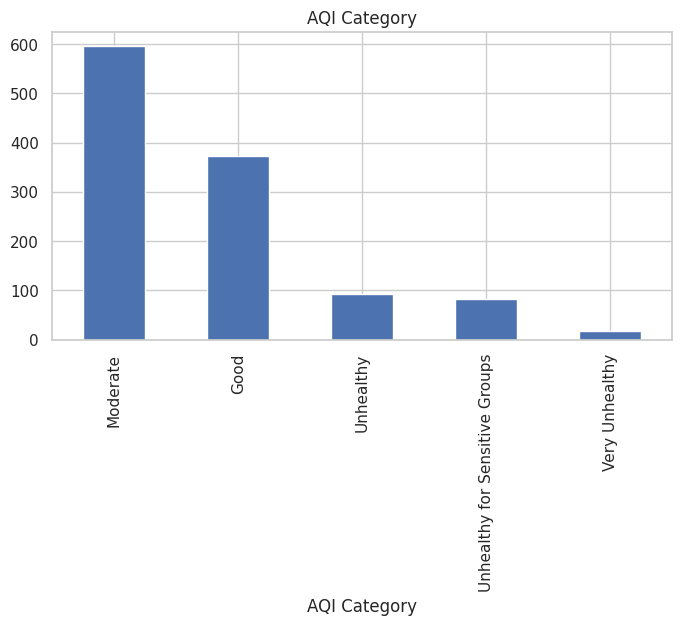

In [ ]:
# Distribution of AQI category
df_asean['AQI Category'].value_counts().plot.bar()
plt.title('AQI Category')
plt.show()

In [ ]:
# Checking the Missing Value
df_asean.isnull().sum()
# there is no missing value for now

Country               0
City                  0
AQI Value             0
AQI Category          0
CO AQI Value          0
CO AQI Category       0
Ozone AQI Value       0
Ozone AQI Category    0
NO2 AQI Value         0
NO2 AQI Category      0
PM2.5 AQI Value       0
PM2.5 AQI Category    0
dtype: int64

In [ ]:
# Checking the Duplicate data
duplicate = df_asean.duplicated().sum()
print(f"There is {duplicate} duplicate data")

There is 0 duplicate data


In [ ]:
df_asean.columns

Index(['Country', 'City', 'AQI Value', 'AQI Category', 'CO AQI Value',
       'CO AQI Category', 'Ozone AQI Value', 'Ozone AQI Category',
       'NO2 AQI Value', 'NO2 AQI Category', 'PM2.5 AQI Value',
       'PM2.5 AQI Category'],
      dtype='object')

In [ ]:
df_num = df_asean.select_dtypes(exclude=["object"])

Outliers: [145, 155, 167, 157, 264, 189, 176, 154, 198, 201, 151, 153, 153, 146, 153, 152, 161, 205, 201, 154, 171, 170, 149, 161, 156, 164, 193, 166, 281, 195, 158, 154, 154, 153, 165, 168, 152, 161, 174, 158, 141, 168, 172, 195, 195, 182, 162, 212, 161, 158, 157, 165, 143, 145, 150, 208, 152, 201, 144, 159, 203, 160, 225, 151, 152, 188, 170, 150, 150, 140, 144, 193, 155, 162, 151, 195, 209, 140, 173, 147, 150, 160, 164, 148, 152, 207, 181, 154, 155, 202, 158, 137, 178, 163, 164, 176, 172, 144, 165, 188, 169, 187, 205, 140, 161, 249, 150, 169, 166, 194, 162, 139, 153, 160, 163, 162, 297, 164, 141, 177, 197, 207, 188, 161, 150, 163, 9, 15, 10, 8, 4, 11, 12, 5, 7, 5, 5, 4, 4, 6, 4, 5, 5, 9, 7, 15, 8, 6, 7, 4, 6, 7, 7, 6, 4, 10, 4, 6, 12, 7, 5, 13, 5, 4, 4, 5, 11, 5, 10, 6, 4, 10, 4, 67, 4, 6, 6, 5, 4, 5, 9, 6, 6, 6, 11, 6, 10, 5, 11, 5, 9, 6, 5, 6, 5, 14, 7, 4, 12, 4, 6, 53, 57, 95, 91, 123, 59, 84, 90, 70, 60, 154, 84, 58, 100, 142, 87, 84, 58, 76, 205, 201, 112, 171, 170, 52, 1, 79, 6

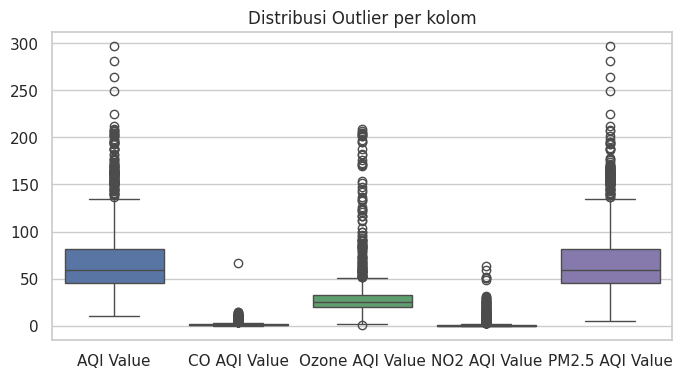

In [ ]:
# Boxplot Outlier Checking
def iqr_outliers(df_num):
    out = []
    numeric_df = df_num.select_dtypes(include=['float64', 'int64'])
    q1 = numeric_df.quantile(0.25)
    q3 = numeric_df.quantile(0.75)
    iqr = q3 - q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for column in numeric_df.columns:
        for i in numeric_df[column]:
            if i > Upper_tail[column] or i < Lower_tail[column]:
                out.append(i)
    print("Outliers:", out)

def Box_plots(df_num):
    plt.figure(figsize=(8, 4))
    plt.title("Distribusi Outlier per kolom")
    sns.boxplot(df_num)
    plt.show()

iqr_outliers(df_num)
Box_plots(df_num)


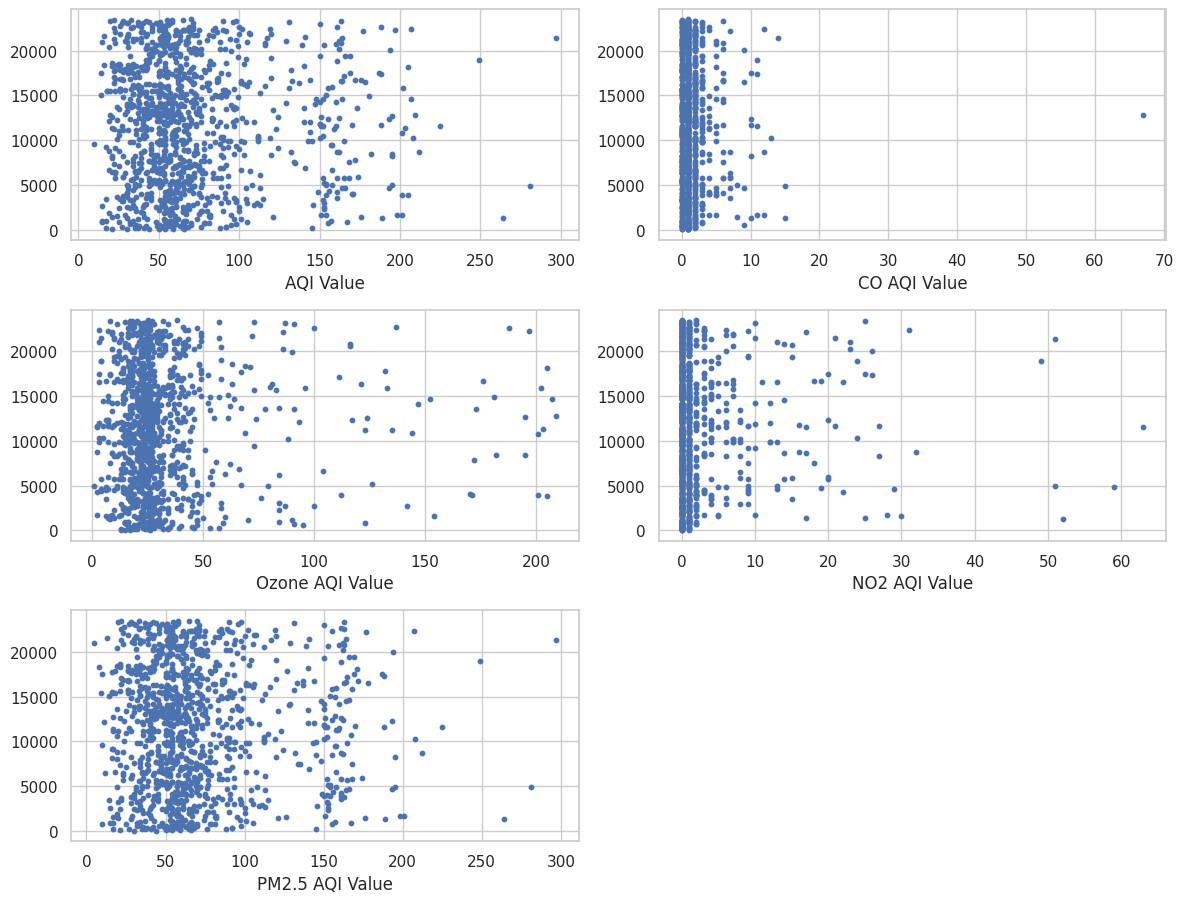

In [ ]:
# Outliers Distribution of each features
num_features = len(df_num.columns)
num_rows = (num_features + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))
axs = axs.flatten()
features = df_num.columns
for i, feature in enumerate(features):
    ax = axs[i]
    ax.scatter(df_num[feature], df_num.index, s=10)
    ax.set_xlabel(feature)

# Hide any unused subplots
for j in range(num_features, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
df_num.head()

AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  PM2.5 AQI Value
31         44             1               15              0               44
55         30             1               17              0               30
66         66             1               26              1               66
96         21             0               13              0               21
99         54             1               20              0               54

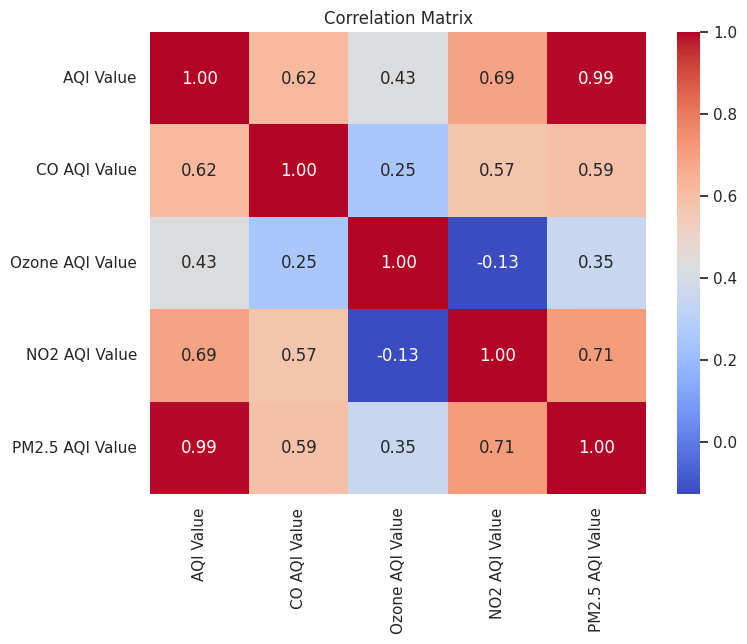

In [ ]:
# Correlation Matrix
corr = df_num.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#3.&nbsp;Data Preprocessing

##3.1&nbsp;Outlier Handling

Jumlah outlier sebelum Winsorization:
AQI Value: 126 outlier (lower: 0, upper: 126)
CO AQI Value: 75 outlier (lower: 0, upper: 75)
Ozone AQI Value: 109 outlier (lower: 1, upper: 108)
NO2 AQI Value: 177 outlier (lower: 0, upper: 177)
PM2.5 AQI Value: 122 outlier (lower: 0, upper: 122)


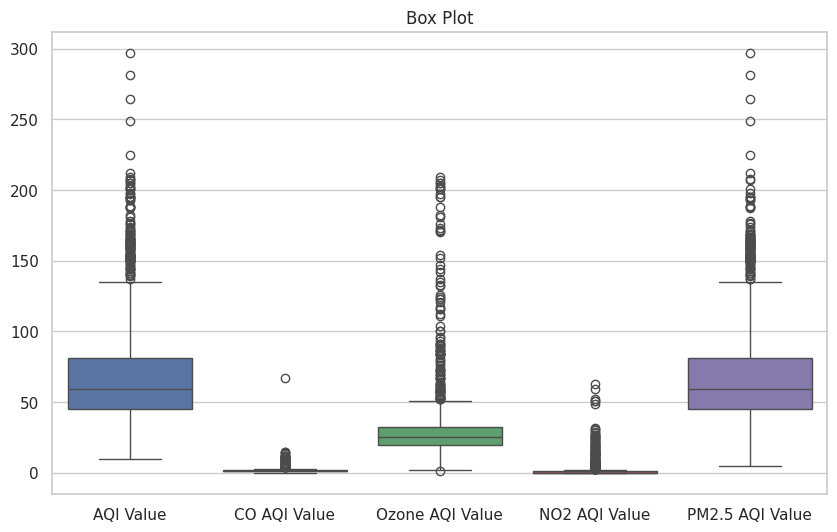

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk menghitung outlier
def calculate_outliers(df, col, limits):
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr_val = q3 - q1
    lower_bound = q1 - limits * iqr_val
    upper_bound = q3 + limits * iqr_val
    lower_outliers = (df[col] < lower_bound).sum()
    upper_outliers = (df[col] > upper_bound).sum()
    total_outliers = lower_outliers + upper_outliers
    return lower_outliers, upper_outliers, total_outliers

def get_outliers_info(df, cols, limits):
    outliers_info = {}
    for col in cols:
        if col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                lower_outliers, upper_outliers, total_outliers = calculate_outliers(df, col, limits)
                outliers_info[col] = {
                    'lower_outliers': lower_outliers,
                    'upper_outliers': upper_outliers,
                    'total_outliers': total_outliers
                }
            else:
                print(f"Kolom '{col}' bukan kolom numerik dan akan dilewati.")
        else:
            print(f"Kolom '{col}' tidak ditemukan dalam DataFrame.")
    return outliers_info

num_cols = ['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']
outliers_info_before = get_outliers_info(df_asean, num_cols, 1.5)

print("Jumlah outlier sebelum Winsorization:")
for col, info in outliers_info_before.items():
    print(f"{col}: {info['total_outliers']} outlier (lower: {info['lower_outliers']}, upper: {info['upper_outliers']})")

# Membuat visualisasi box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_asean[num_cols])
plt.title('Box Plot')
plt.show()


In [ ]:
df_clean = df_asean.copy()

def winsorize(df_clean, cols, limits):
    """
    Melakukan Winsorization pada kolom-kolom numerik yang ditentukan.

    Args:
        df_clean (pandas.DataFrame): DataFrame yang akan diwinsorize.
        cols (list): Daftar kolom numerik yang akan diwinsorize.
        limits (float): Batas atas dan bawah untuk Winsorization, dinyatakan dalam kelipatan IQR.

    Returns:
        pandas.DataFrame: DataFrame yang telah diwinsorize.
    """
    for col in cols:
        q1, q3 = df_clean[col].quantile([0.25, 0.75])
        iqr_val = q3 - q1
        lower_bound = q1 - limits * iqr_val
        upper_bound = q3 + limits * iqr_val
        df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)
    return df_clean

num_col = ['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']

df_clean2 = winsorize(df_clean, num_col, 1.5)

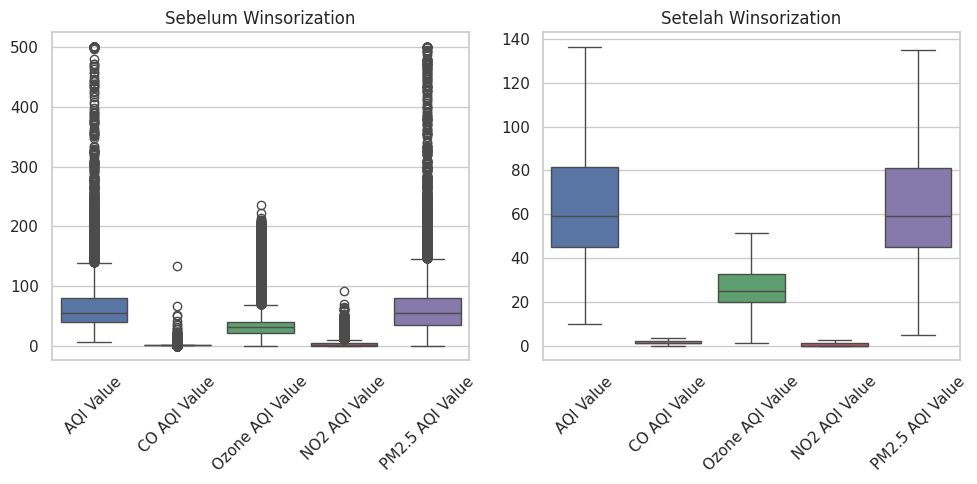

In [ ]:
# boxplot before
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[num_col])
plt.title('Sebelum Winsorization')
plt.xticks(rotation=45)

# boxplot after
plt.subplot(1, 2, 2)
sns.boxplot(data=df_clean2[num_col])
plt.title('Setelah Winsorization')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
df_clean2.shape

(1159, 12)

##3.2.&nbsp;Feature Engineering

In [ ]:
def get_coordinates(city, country, attempts=5, timeout=10):
    geolocator = Nominatim(user_agent="test_geo")
    for attempt in range(attempts):
        try:
            location = geolocator.geocode(f"{city}, {country}", timeout=timeout)
            if location:
                return location.latitude, location.longitude
            else:
                return None, None
        except (GeocoderTimedOut, GeocoderServiceError) as e:
            if attempt < attempts - 1:
                time.sleep(1)
                continue
            else:
                print(f"Error: {e}")
                return None, None

asean_geocoding = df_clean2.copy()

# Create Lat & Lon columns
asean_geocoding['Latitude'] = None
asean_geocoding['Longitude'] = None

for index, row in asean_geocoding.iterrows():
    city = row['City']
    country = row['Country']
    latitude, longitude = get_coordinates(city, country)
    asean_geocoding.at[index, 'Latitude'] = latitude
    asean_geocoding.at[index, 'Longitude'] = longitude

asean_geocoding

Country                 City  AQI Value AQI Category  CO AQI Value  \
31       Indonesia            Pontianak       44.0         Good           1.0   
55     Philippines              Dipolog       30.0         Good           1.0   
66     Philippines               Guiset       66.0     Moderate           1.0   
96       Indonesia               Tidore       21.0         Good           0.0   
99     Philippines               Toboso       54.0     Moderate           1.0   
...            ...                  ...        ...          ...           ...   
23392      Myanmar              Paungde       33.0         Good           1.0   
23415     Thailand  Nakhon Si Thammarat       58.0     Moderate           1.0   
23424    Indonesia            Kabanjahe       22.0         Good           0.0   
23437  Philippines               Teresa       65.0     Moderate           1.0   
23462     Malaysia               Marang       70.0     Moderate           1.0   

      CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
31               Good             15.0               Good            0.0   
55               Good             17.0               Good            0.0   
66               Good             26.0               Good            1.0   
96               Good             13.0               Good            0.0   
99               Good             20.0               Good            0.0   
...               ...              ...                ...            ...   
23392            Good             17.0               Good            0.0   
23415            Good             32.0               Good            0.0   
23424            Good             18.0               Good            0.0   
23437            Good             25.0               Good            2.0   
23462            Good             38.0               Good            0.0   

      NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category   Latitude  \
31                Good               44               Good   -0.02269   
55                Good               30               Good   8.586406   
66                Good               66           Moderate  15.720875   
96                Good               21               Good    0.67868   
99                Good               54           Moderate  10.716947   
...                ...              ...                ...        ...   
23392             Good               33               Good  18.492834   
23415             Good               58           Moderate   8.677234   
23424             Good               22               Good    3.10091   
23437             Good               65           Moderate  14.558895   
23462             Good               70           Moderate   5.166667   

        Longitude  
31     109.344749  
55     123.344937  
66     120.777514  
96     127.448316  
99     123.513558  
...           ...  
23392   95.507161  
23415   99.730964  
23424   98.489122  
23437  121.207946  
23462  103.166667  

[1159 rows x 14 columns]

In [ ]:
asean_geocoding.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1159 entries, 31 to 23462
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             1159 non-null   object 
 1   City                1159 non-null   object 
 2   AQI Value           1159 non-null   float64
 3   AQI Category        1159 non-null   object 
 4   CO AQI Value        1159 non-null   float64
 5   CO AQI Category     1159 non-null   object 
 6   Ozone AQI Value     1159 non-null   float64
 7   Ozone AQI Category  1159 non-null   object 
 8   NO2 AQI Value       1159 non-null   float64
 9   NO2 AQI Category    1159 non-null   object 
 10  PM2.5 AQI Value     1159 non-null   int64  
 11  PM2.5 AQI Category  1159 non-null   object 
 12  Latitude            1144 non-null   object 
 13  Longitude           1144 non-null   object 
dtypes: float64(4), int64(1), object(9)
memory usage: 168.1+ KB


In [ ]:
asean_geocoding['Latitude'] = asean_geocoding['Latitude'].astype(float)
asean_geocoding['Longitude'] = asean_geocoding['Longitude'].astype(float)

In [ ]:
asean_geocoding.head()

Country       City  AQI Value AQI Category  CO AQI Value  \
31    Indonesia  Pontianak       44.0         Good           1.0   
55  Philippines    Dipolog       30.0         Good           1.0   
66  Philippines     Guiset       66.0     Moderate           1.0   
96    Indonesia     Tidore       21.0         Good           0.0   
99  Philippines     Toboso       54.0     Moderate           1.0   

   CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
31            Good             15.0               Good            0.0   
55            Good             17.0               Good            0.0   
66            Good             26.0               Good            1.0   
96            Good             13.0               Good            0.0   
99            Good             20.0               Good            0.0   

   NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category   Latitude   Longitude  
31             Good               44               Good  -0.022690  109.344749  
55             Good               30               Good   8.586406  123.344937  
66             Good               66           Moderate  15.720875  120.777514  
96             Good               21               Good   0.678680  127.448316  
99             Good               54           Moderate  10.716947  123.513558

In [ ]:
# Drop non-informative categorical features
cat_drop = ['AQI Category', 'CO AQI Category', 'Ozone AQI Category', 'NO2 AQI Category', 'PM2.5 AQI Category']
df_asean2 = asean_geocoding.drop(columns=cat_drop)
df_asean2.head()


Country       City  AQI Value  CO AQI Value  Ozone AQI Value  \
31    Indonesia  Pontianak       44.0           1.0             15.0   
55  Philippines    Dipolog       30.0           1.0             17.0   
66  Philippines     Guiset       66.0           1.0             26.0   
96    Indonesia     Tidore       21.0           0.0             13.0   
99  Philippines     Toboso       54.0           1.0             20.0   

    NO2 AQI Value  PM2.5 AQI Value   Latitude   Longitude  
31            0.0               44  -0.022690  109.344749  
55            0.0               30   8.586406  123.344937  
66            1.0               66  15.720875  120.777514  
96            0.0               21   0.678680  127.448316  
99            0.0               54  10.716947  123.513558

##3.3 Missing Value Handling

In [ ]:
# Lets check the missing value of each cols after geocoding
df_asean2.isnull().sum()

Country             0
City                0
AQI Value           0
CO AQI Value        0
Ozone AQI Value     0
NO2 AQI Value       0
PM2.5 AQI Value     0
Latitude           15
Longitude          15
dtype: int64

In [ ]:
# Missing value in percentage
missing_percnt = df_asean2.isnull().mean() * 100
missing_percnt

Country            0.000000
City               0.000000
AQI Value          0.000000
CO AQI Value       0.000000
Ozone AQI Value    0.000000
NO2 AQI Value      0.000000
PM2.5 AQI Value    0.000000
Latitude           1.294219
Longitude          1.294219
dtype: float64

In [ ]:
# Drop rows of missing value
asean_clean = df_asean2.dropna(axis=0)
asean_clean.isnull().sum()

Country            0
City               0
AQI Value          0
CO AQI Value       0
Ozone AQI Value    0
NO2 AQI Value      0
PM2.5 AQI Value    0
Latitude           0
Longitude          0
dtype: int64

In [ ]:
# Optional if cleaned asean df needed
# asean_clean.to_csv('ASEAN Clean.csv', index=False)

##3.4 Data Scaling

In [ ]:
df_asean_scaled = asean_clean.copy()

scaler = StandardScaler()

# Features that will be scaled
fitur = ['CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']

# Scaling
df_asean_scaled[fitur] = scaler.fit_transform(df_asean_scaled[fitur])
df_asean_scaled.head()

Country       City  AQI Value  CO AQI Value  Ozone AQI Value  \
31    Indonesia  Pontianak       44.0     -0.213874        -1.026408   
55  Philippines    Dipolog       30.0     -0.213874        -0.857070   
66  Philippines     Guiset       66.0     -0.213874        -0.095049   
96    Indonesia     Tidore       21.0     -1.248428        -1.195746   
99  Philippines     Toboso       54.0     -0.213874        -0.603063   

    NO2 AQI Value  PM2.5 AQI Value   Latitude   Longitude  
31      -0.753647        -0.708683  -0.022690  109.344749  
55      -0.753647        -1.139580   8.586406  123.344937  
66       0.306835        -0.031559  15.720875  120.777514  
96      -0.753647        -1.416585   0.678680  127.448316  
99      -0.753647        -0.400899  10.716947  123.513558

#4.&nbsp;Modeling

Dengan clustering, kita dapat mudah menentukan aksi dan solusi dalam mengurangi hingga mitigasi polusi udara yang terjadi di setiap cluster. Alih-alih melakukan identifikasi setiap kota secara individual, dengan clustering kita dapat secara masif melakukan analisis pola dan karakteristik polusi udara di berbagai wilayah. Dengan demikian, kita dapat mengidentifikasi solusi yang lebih efisien dan tepat sasaran untuk mengurangi dampak polusi udara secara keseluruhan, sehingga dapat mengurangi biaya yang terkait dengan implementasi tindakan mitigasi.

In [ ]:
# Save the cleaned dataframe to csv, because the geocoding process took to long time
# So if want to do further modeling without waiting, can use this CSV as dataframe (df_scaled)
# df_asean_scaled.to_csv('df_scaled.csv', index=False)

In [ ]:
# Run this block code if the dataframe is from df_scaled
# asean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone Project/df_scaled.csv')

In [ ]:
# Drop "Latitude" & "Longitude", prevent from being processed by the model
# cleaned_asean = asean.drop(columns=['Country', 'City','AQI Value', 'Latitude', 'Longitude'])
cleaned_asean = df_asean_scaled.drop(columns=['Country', 'City', 'AQI Value', 'Latitude', 'Longitude'])
cleaned_asean.head()

CO AQI Value  Ozone AQI Value  NO2 AQI Value  PM2.5 AQI Value
31     -0.213874        -1.026408      -0.753647        -0.708683
55     -0.213874        -0.857070      -0.753647        -1.139580
66     -0.213874        -0.095049       0.306835        -0.031559
96     -1.248428        -1.195746      -0.753647        -1.416585
99     -0.213874        -0.603063      -0.753647        -0.400899

In [ ]:
df_asean_scaled.head()

Country       City  AQI Value  CO AQI Value  Ozone AQI Value  \
31    Indonesia  Pontianak       44.0     -0.213874        -1.026408   
55  Philippines    Dipolog       30.0     -0.213874        -0.857070   
66  Philippines     Guiset       66.0     -0.213874        -0.095049   
96    Indonesia     Tidore       21.0     -1.248428        -1.195746   
99  Philippines     Toboso       54.0     -0.213874        -0.603063   

    NO2 AQI Value  PM2.5 AQI Value   Latitude   Longitude  
31      -0.753647        -0.708683  -0.022690  109.344749  
55      -0.753647        -1.139580   8.586406  123.344937  
66       0.306835        -0.031559  15.720875  120.777514  
96      -0.753647        -1.416585   0.678680  127.448316  
99      -0.753647        -0.400899  10.716947  123.513558

##4.1 K-Means Clustering

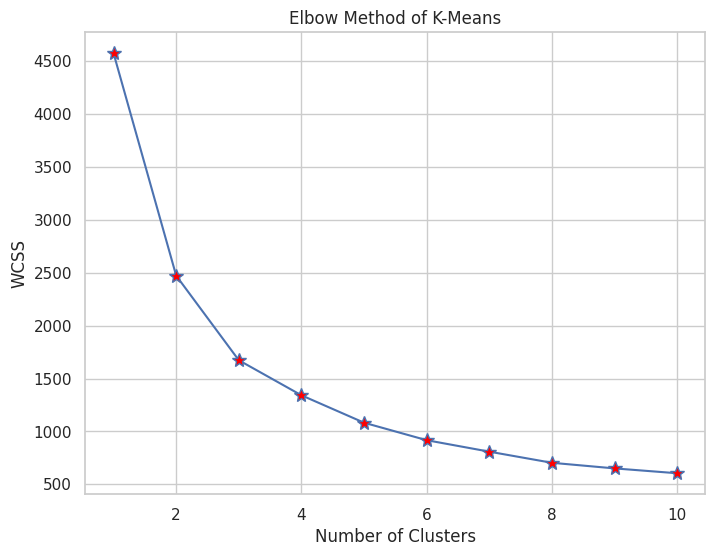

In [ ]:
range_n_clusters = list(range(1, 11))
wcss = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(cleaned_asean)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, wcss, marker='*', markersize=10, markerfacecolor='red')
plt.title('Elbow Method of K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

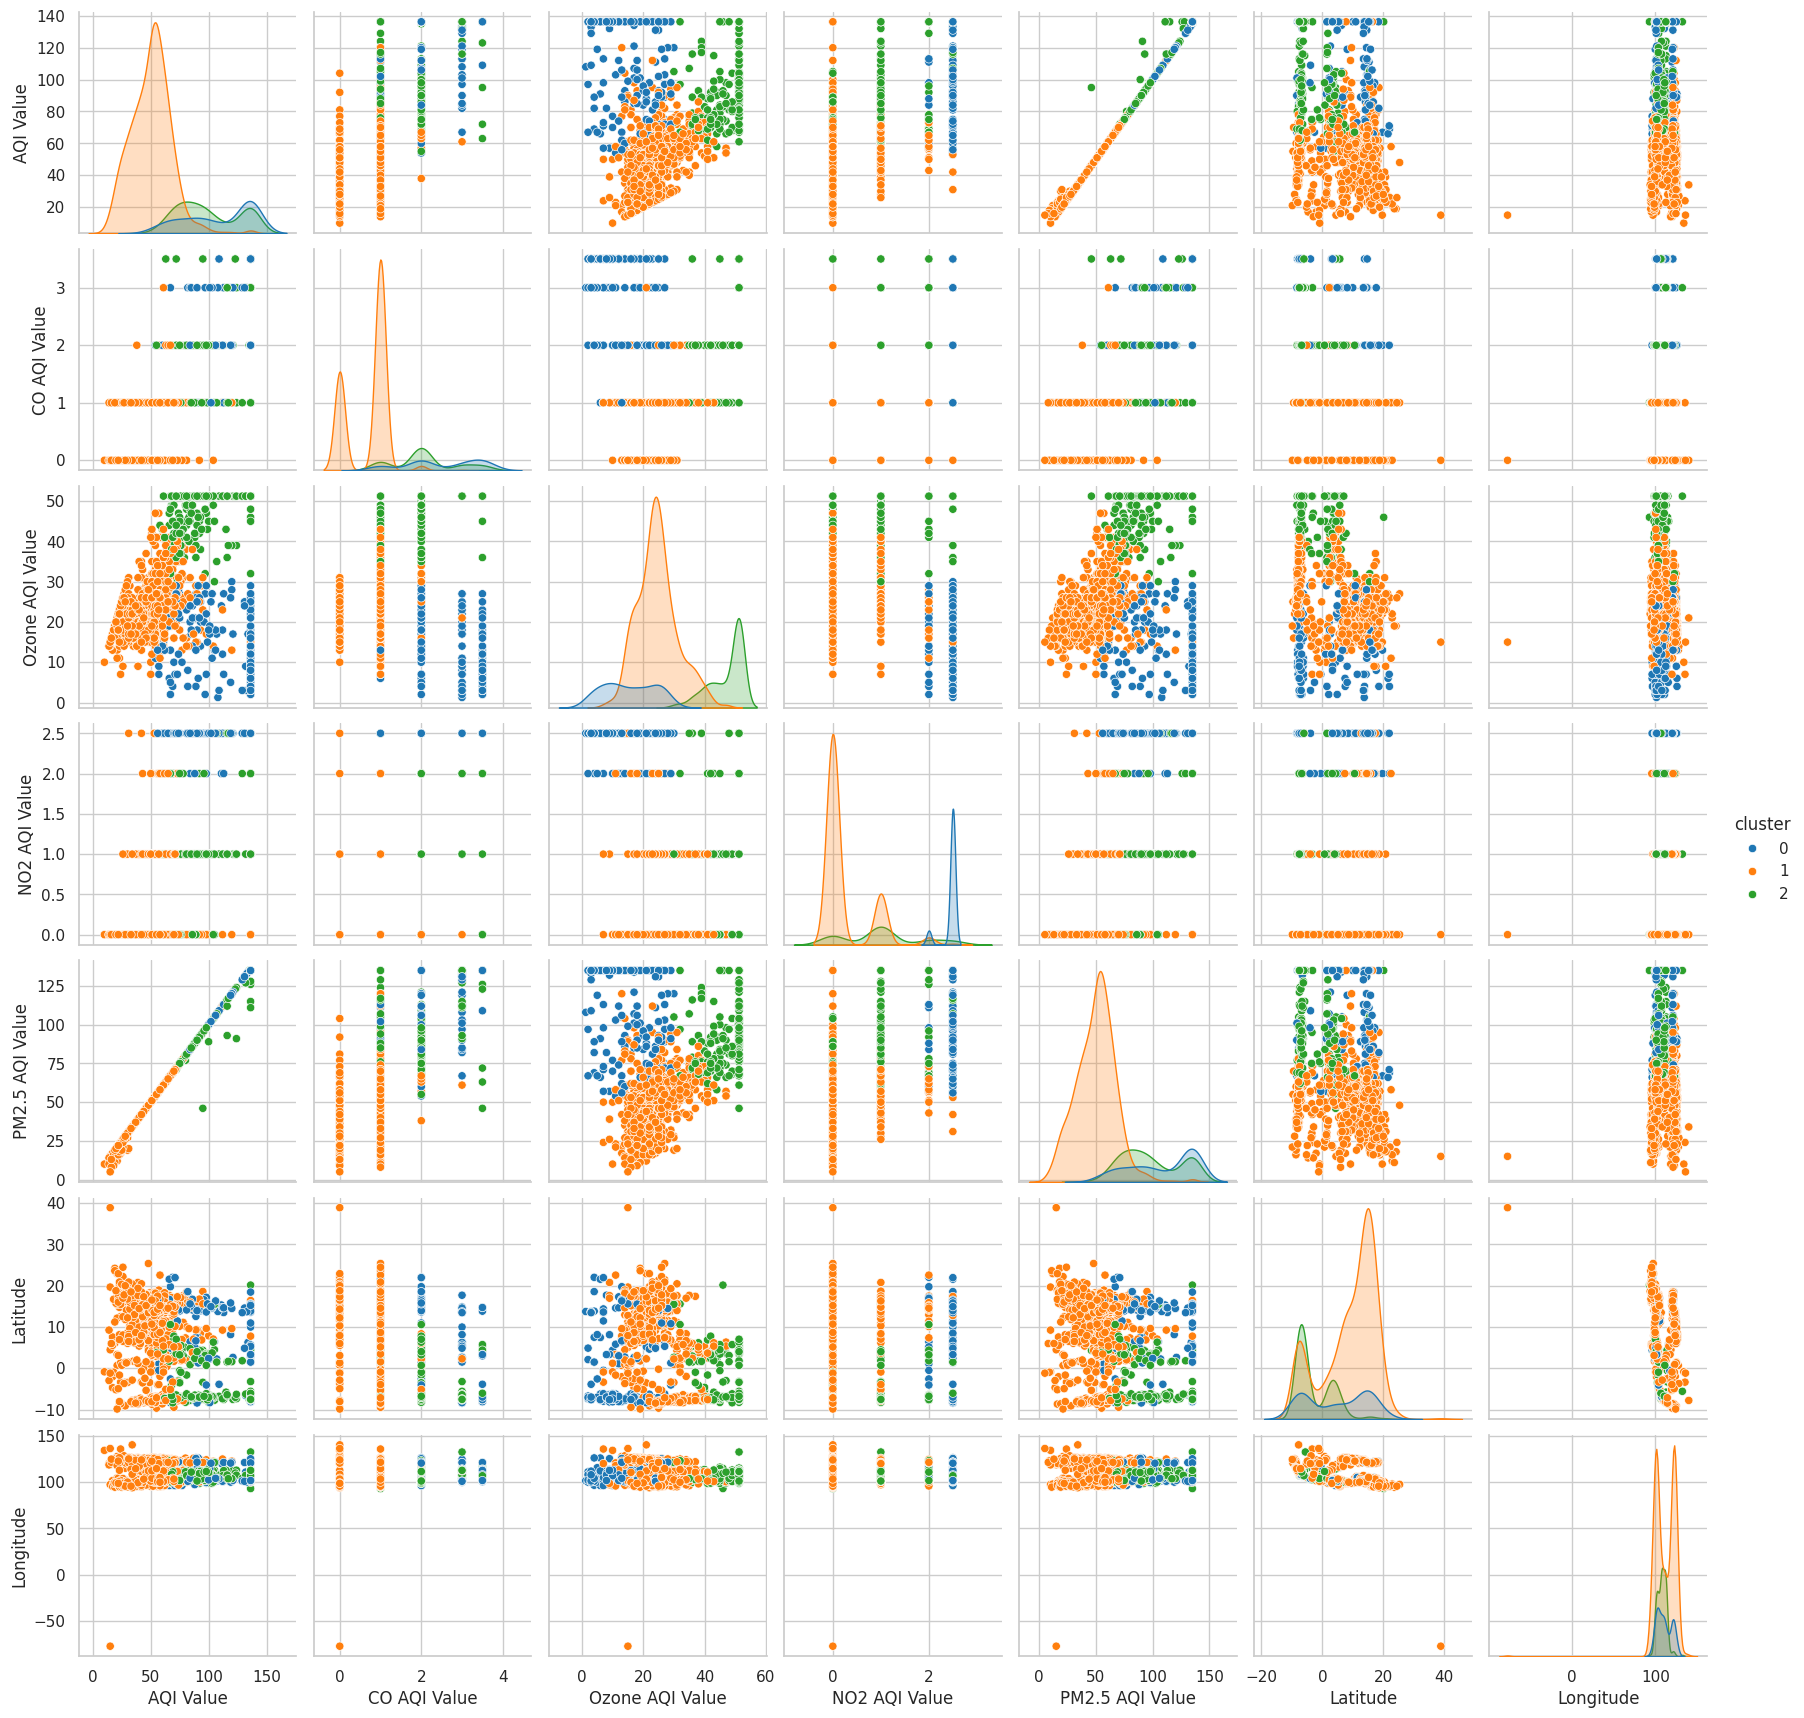

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(cleaned_asean)

df_result_kmeans = asean_clean.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='kde',
    palette='tab10'
)

plt.show();

In [ ]:
df_result_kmeans.head()

Country       City  AQI Value  CO AQI Value  Ozone AQI Value  \
31    Indonesia  Pontianak       44.0           1.0             15.0   
55  Philippines    Dipolog       30.0           1.0             17.0   
66  Philippines     Guiset       66.0           1.0             26.0   
96    Indonesia     Tidore       21.0           0.0             13.0   
99  Philippines     Toboso       54.0           1.0             20.0   

    NO2 AQI Value  PM2.5 AQI Value   Latitude   Longitude  cluster  
31            0.0               44  -0.022690  109.344749        1  
55            0.0               30   8.586406  123.344937        1  
66            1.0               66  15.720875  120.777514        1  
96            0.0               21   0.678680  127.448316        1  
99            0.0               54  10.716947  123.513558        1

In [ ]:
df_result_kmeans.to_csv('ASEAN Clean with Cluster.csv', index=False)

In [ ]:
df_kmeans_cluster = df_result_kmeans.sort_values(by='cluster').copy()

cluster_dfs = {}
for cluster in df_kmeans_cluster['cluster'].unique():
    cluster_dfs[cluster] = df_kmeans_cluster[df_kmeans_cluster['cluster'] == cluster].copy()

df_kmeans_cluster.head()

Country      City  AQI Value  CO AQI Value  Ozone AQI Value  \
8649   Philippines  Halayhay      60.00           1.0             26.0   
15030     Thailand     Surin      85.00           2.0             18.0   
17491    Indonesia    Madiun     136.25           3.5              3.0   
15021  Philippines    Tarlac     136.25           2.0             25.0   
13357  Philippines      Tuba      55.00           1.0             25.0   

       NO2 AQI Value  PM2.5 AQI Value   Latitude   Longitude  cluster  
8649             2.5               60  14.374011  120.812271        0  
15030            2.5               85  15.061014  103.761312        0  
17491            2.5              135  -7.611888  111.673193        0  
15021            2.5              135  15.493725  120.496409        0  
13357            2.5               55  16.392703  120.560201        0

Create separate dataframe for each cluster

In [ ]:
kmeans_cluster0 = cluster_dfs[0]
kmeans_cluster0

Country        City  AQI Value  CO AQI Value  Ozone AQI Value  \
8649   Philippines    Halayhay      60.00           1.0             26.0   
15030     Thailand       Surin      85.00           2.0             18.0   
17491    Indonesia      Madiun     136.25           3.5              3.0   
15021  Philippines      Tarlac     136.25           2.0             25.0   
13357  Philippines        Tuba      55.00           1.0             25.0   
...            ...         ...        ...           ...              ...   
1311     Indonesia  Leuwiliang     136.25           3.5              8.0   
11674    Indonesia      Grogol     136.25           3.5              7.0   
23185     Malaysia     Taiping     131.00           3.0             24.0   
11651    Indonesia     Soreang     136.25           3.5              5.0   
5770   Philippines       Mawab      89.00           2.0              4.0   

       NO2 AQI Value  PM2.5 AQI Value   Latitude   Longitude  cluster  
8649             2.5               60  14.374011  120.812271        0  
15030            2.5               85  15.061014  103.761312        0  
17491            2.5              135  -7.611888  111.673193        0  
15021            2.5              135  15.493725  120.496409        0  
13357            2.5               55  16.392703  120.560201        0  
...              ...              ...        ...         ...      ...  
1311             2.5              135  -6.574516  106.634385        0  
11674            2.5              135  -6.162071  106.788875        0  
23185            2.5              131   4.854677  100.743883        0  
11651            2.5              135  -7.026868  107.516796        0  
5770             2.5               89   7.507642  125.920714        0  

[169 rows x 10 columns]

In [ ]:
kmeans_cluster1 = cluster_dfs[1]
kmeans_cluster1

Country            City  AQI Value  CO AQI Value  Ozone AQI Value  \
15740     Thailand           Phrae       62.0           0.0             24.0   
15676      Myanmar          Syriam       62.0           0.0             23.0   
14613  Philippines       Calintaan       32.0           0.0             25.0   
14704    Indonesia       Rajapolah       58.0           1.0             35.0   
14659     Thailand  Bang Sao Thong       59.0           1.0             20.0   
...            ...             ...        ...           ...              ...   
10952     Thailand      Udon Thani       54.0           0.0             25.0   
7288     Indonesia         Gombong       63.0           1.0             37.0   
10923      Myanmar       Thanatpin       59.0           0.0             23.0   
7336     Indonesia       Singosari       72.0           1.0             36.0   
10916  Philippines         Tagbina       52.0           1.0             20.0   

       NO2 AQI Value  PM2.5 AQI Value   Latitude   Longitude  cluster  
15740            0.0               62  18.293060  100.088676        1  
15676            0.0               62  16.764813   96.250947        1  
14613            0.0               32  10.271681  125.246158        1  
14704            0.0               58  -7.241751  108.184442        1  
14659            1.0               59  13.600275  100.820074        1  
...              ...              ...        ...         ...      ...  
10952            0.0               54  17.521192  102.668001        1  
7288             0.0               63  -7.610747  109.507805        1  
10923            0.0               59  17.293280   96.578613        1  
7336             1.0               72  -7.892550  112.666452        1  
10916            0.0               52   8.457357  126.159072        1  

[776 rows x 10 columns]

In [ ]:
kmeans_cluster2 = cluster_dfs[2]
kmeans_cluster2

Country            City  AQI Value  CO AQI Value  Ozone AQI Value  \
11536   Malaysia  Tanjong Karang      69.00           2.0            45.00   
12141  Indonesia          Lawang      83.00           2.0            40.00   
20948  Indonesia        Bengkulu      75.00           2.0            37.00   
9985    Malaysia        Beranang      90.00           2.0            44.00   
11258  Indonesia           Babat     136.25           3.0            51.25   
...          ...             ...        ...           ...              ...   
13572  Indonesia        Cibinong     136.25           3.5            51.25   
13571  Indonesia         Cianjur      96.00           2.0            51.25   
13536  Indonesia          Cisaat     136.25           2.0            51.25   
13512  Indonesia       Bulakamba      83.00           2.0            45.00   
16887  Indonesia            Weru      68.00           2.0            49.00   

       NO2 AQI Value  PM2.5 AQI Value  Latitude   Longitude  cluster  
11536            2.0               69  3.424861  101.176528        2  
12141            1.0               83 -7.836624  112.697759        2  
20948            0.0               75 -3.518676  102.535983        2  
9985             1.0               90  2.874611  101.871986        2  
11258            1.0              135 -3.220707  104.058627        2  
...              ...              ...       ...         ...      ...  
13572            2.5              135 -6.482436  106.838327        2  
13571            1.0               96 -6.824624  107.142685        2  
13536            1.0              135 -6.917895  106.867208        2  
13512            1.0               83 -6.874820  108.956601        2  
16887            0.0               68 -6.878124  112.450776        2  

[199 rows x 10 columns]

Data Statistics Description of each cluster of K-means clustering

In [ ]:
print("Descriptive statistics of cluster 0")
kmeans_cluster0.describe()

Descriptive statistics of cluster 0


AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  \
count  169.000000    169.000000       169.000000     169.000000   
mean   108.900888      2.500000        15.374260       2.452663   
std     28.779892      0.893095         8.159274       0.146817   
min     53.000000      1.000000         1.250000       2.000000   
25%     85.000000      2.000000         8.000000       2.500000   
50%    113.000000      2.000000        15.000000       2.500000   
75%    136.250000      3.500000        23.000000       2.500000   
max    136.250000      3.500000        30.000000       2.500000   

       PM2.5 AQI Value    Latitude   Longitude  cluster  
count       169.000000  169.000000  169.000000    169.0  
mean        108.360947    4.896855  110.355785      0.0  
std          28.265849    9.958222    8.447499      0.0  
min          53.000000   -8.404607   96.094874      0.0  
25%          85.000000   -6.896266  102.376764      0.0  
50%         113.000000    5.643520  109.240850      0.0  
75%         135.000000   14.444314  120.475388      0.0  
max         135.000000   22.033137  125.920714      0.0

In [ ]:
print("Descriptive statistics of cluster 1")
kmeans_cluster1.describe()

Descriptive statistics of cluster 1


AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  \
count  776.000000    776.000000       776.000000     776.000000   
mean    50.267719      0.702320        24.538660       0.253222   
std     17.155402      0.495445         6.606823       0.507990   
min     10.000000      0.000000         7.000000       0.000000   
25%     39.000000      0.000000        20.000000       0.000000   
50%     51.000000      1.000000        24.000000       0.000000   
75%     61.000000      1.000000        28.000000       0.000000   
max    136.250000      3.000000        47.000000       2.500000   

       PM2.5 AQI Value    Latitude   Longitude  cluster  
count       776.000000  776.000000  776.000000    776.0  
mean         50.015464    8.952649  111.132860      1.0  
std          17.571010    8.764461   12.527979      0.0  
min           5.000000   -9.869322  -77.038133      1.0  
25%          39.000000    4.425670  101.053669      1.0  
50%          51.000000   12.093519  110.651161      1.0  
75%          61.000000   15.229542  121.346606      1.0  
max         135.000000   38.907488  140.018325      1.0

In [ ]:
print("Descriptive statistics of cluster 2")
kmeans_cluster2.describe()

Descriptive statistics of cluster 2


AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  \
count  199.000000    199.000000       199.000000     199.000000   
mean    99.515075      2.075377        47.175879       1.015075   
std     25.901263      0.760015         5.520666       0.778352   
min     54.000000      1.000000        30.000000       0.000000   
25%     78.000000      2.000000        43.000000       0.000000   
50%     93.000000      2.000000        51.250000       1.000000   
75%    135.625000      2.000000        51.250000       1.000000   
max    136.250000      3.500000        51.250000       2.500000   

       PM2.5 AQI Value    Latitude   Longitude  cluster  
count       199.000000  199.000000  199.000000    199.0  
mean         98.251256   -2.897799  107.503300      2.0  
std          25.307546    5.787053    5.360654      0.0  
min          46.000000   -8.362514   92.900000      2.0  
25%          77.000000   -7.124765  103.365615      2.0  
50%          92.000000   -6.463547  107.443980      2.0  
75%         126.500000    2.731349  111.235965      2.0  
max         135.000000   20.150000  132.308333      2.0

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)
col_drop = ['Latitude','Longitude', 'Country', 'City']
# Simple descriptive statistic
(
    df_result_kmeans
    .drop(col_drop, axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                          0           1           2
AQI Value       mean    108.900888   50.267719   99.515075
                std      28.779892   17.155402   25.901263
                min      53.000000   10.000000   54.000000
                q25      85.000000   39.000000   78.000000
                median  113.000000   51.000000   93.000000
                q75     136.250000   61.000000  135.625000
                max     136.250000  136.250000  136.250000
CO AQI Value    mean      2.500000    0.702320    2.075377
                std       0.893095    0.495445    0.760015
                min       1.000000    0.000000    1.000000
                q25       2.000000    0.000000    2.000000
                median    2.000000    1.000000    2.000000
                q75       3.500000    1.000000    2.000000
                max       3.500000    3.000000    3.500000
Ozone AQI Value mean     15.374260   24.538660   47.175879
                std       8.159274    6.606823    5.520666
                min       1.250000    7.000000   30.000000
                q25       8.000000   20.000000   43.000000
                median   15.000000   24.000000   51.250000
                q75      23.000000   28.000000   51.250000
                max      30.000000   47.000000   51.250000
NO2 AQI Value   mean      2.452663    0.253222    1.015075
                std       0.146817    0.507990    0.778352
                min       2.000000    0.000000    0.000000
                q25       2.500000    0.000000    0.000000
                median    2.500000    0.000000    1.000000
                q75       2.500000    0.000000    1.000000
                max       2.500000    2.500000    2.500000
PM2.5 AQI Value mean    108.360947   50.015464   98.251256
                std      28.265849   17.571010   25.307546
                min      53.000000    5.000000   46.000000
                q25      85.000000   39.000000   77.000000
                median  113.000000   51.000000   92.000000
                q75     135.000000   61.000000  126.500000
                max     135.000000  135.000000  135.000000

**Insight**
1. Kluster 0 memiliki nilai AQI yang paling tinggi secara rata-rata, terutama dipengaruhi oleh komponen PM2.5 dan CO yang tinggi. Rentang nilai AQI juga menunjukkan bahwa kluster ini secara konsisten memiliki kualitas udara yang lebih buruk dibanding kluster lainnya.
2. Kluster 1 memiliki nilai AQI yang paling rendah secara rata-rata, dengan nilai komponen CO dan NO2 yang sangat rendah. Ini menunjukkan bahwa kluster ini memiliki kualitas udara terbaik dibanding kluster lainnya.
3. Kluster 2 memiliki nilai AQI yang berada di tengah-tengah antara kluster 0 dan 1. Namun, nilai Ozone dalam kluster ini cukup tinggi dibanding kluster lainnya, menunjukkan potensi masalah kualitas udara terkait dengan ozon.

##4.2 Agglomerative Hierarchical Clustering


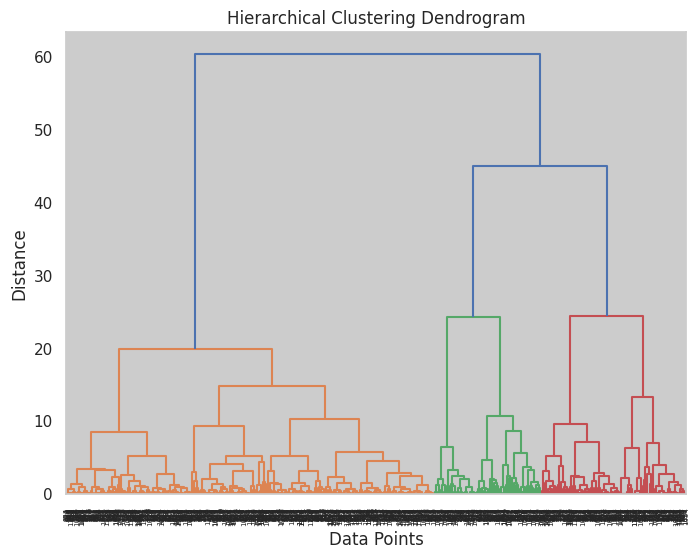

In [ ]:
Z = linkage(cleaned_asean, method='ward')

plt.figure(figsize=(8, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


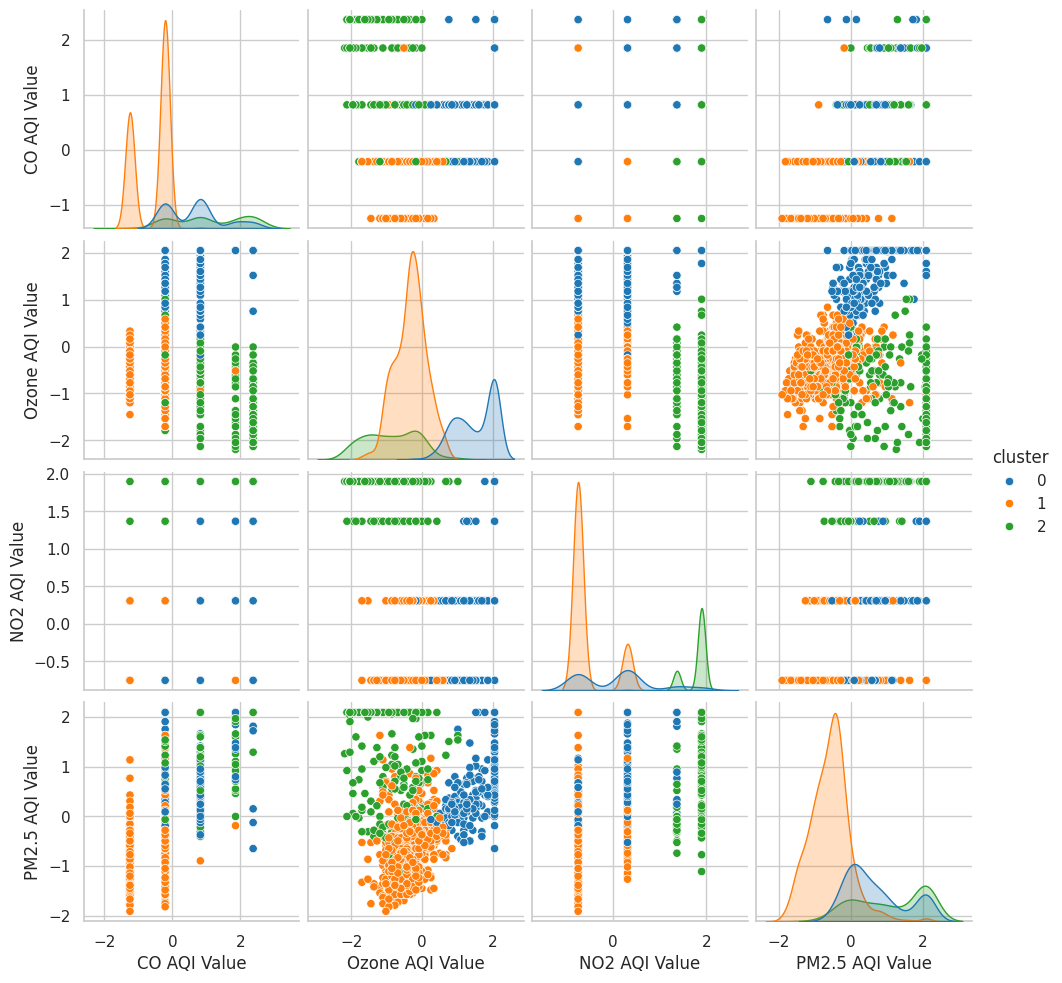

In [ ]:
ahc = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(cleaned_asean)

df_result_ahc = cleaned_asean.copy()
df_result_ahc['cluster'] = ahc.labels_

sns.pairplot(
    data=df_result_ahc,
    hue='cluster',
    diag_kind='kde',
    palette='tab10',
)

plt.show()

#5.&nbsp;Model Evaluation

In [ ]:
# Evaluation Kmeans
kmeans_dbi = davies_bouldin_score(cleaned_asean, kmeans.labels_)
kmeans_sil = silhouette_score(cleaned_asean, kmeans.labels_)

print('K-Means Clustering')
print(f'Davies-Bouldin Index: {kmeans_dbi:.5f}')
print(f'Silhouette Score: {kmeans_sil:.5f} \n')

ahc_dbi = davies_bouldin_score(cleaned_asean, ahc.labels_)
ahc_sil = silhouette_score(cleaned_asean, ahc.labels_)

print('Agglomerative Hierarchical Clustering')
print(f'Davies-Bouldin Index: {ahc_dbi:.5f}')
print(f'Silhouette Score: {ahc_sil:.5f}')

K-Means Clustering
Davies-Bouldin Index: 0.83483
Silhouette Score: 0.49687 

Agglomerative Hierarchical Clustering
Davies-Bouldin Index: 0.93854
Silhouette Score: 0.45291


#6.&nbsp;Feature Importance

In [ ]:
# Fungsi untuk melakukan analisis SHAP pada model Random Forest
def rf_shap_analysis(X, y):
    model = RandomForestRegressor().fit(X, y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, show=False)
    plt.show()

# Fungsi untuk menghitung pentingnya fitur menggunakan model Random Forest
def get_feature_importance(X, y):
    rf = RandomForestRegressor(n_estimators=100, random_state=0)
    rf.fit(X, y)
    return pd.Series(rf.feature_importances_, index=X.columns).sort_values()

# Menampilkan pentingnya fitur dan plot untuk setiap kluster
def display_cluster(cluster_data, cluster_number):
    columns_to_drop = ['AQI Value', 'Country', 'City', 'Latitude', 'Longitude', 'cluster']
    X = cluster_data.drop(columns=[col for col in columns_to_drop if col in cluster_data.columns])
    y = cluster_data['AQI Value']

    feature_importance = get_feature_importance(X, y)

    print(f"Feature Importances for Cluster {cluster_number}:\n", feature_importance)
    feature_importance.plot(kind='barh', figsize=(8, 4))
    plt.title(f'Feature Importance for Cluster {cluster_number}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Analisis dan visualisasi SHAP serta pentingnya fitur untuk setiap kluster
def analyze_cluster(cluster_data, cluster_number):
    columns_to_drop = ['AQI Value', 'Country', 'City', 'Latitude', 'Longitude', 'cluster']
    X = cluster_data.drop(columns=[col for col in columns_to_drop if col in cluster_data.columns])
    y = cluster_data['AQI Value']

    print(f"SHAP Summary Plot for Cluster {cluster_number}:")
    rf_shap_analysis(X, y)

    display_cluster(cluster_data, cluster_number)

# # Memastikan bahwa data kluster tersedia dan dalam bentuk dictionary
# df_kmeans_cluster = df_result_kmeans.sort_values(by='cluster').copy()

# cluster_dfs = {}
# for cluster in df_kmeans_cluster['cluster'].unique():
#     cluster_dfs[cluster] = df_kmeans_cluster[df_kmeans_cluster['cluster'] == cluster].copy()

def analyze_specific_cluster(cluster_number):
    if cluster_number in cluster_dfs:
        print(f"Cluster {cluster_number}:")
        analyze_cluster(cluster_dfs[cluster_number], cluster_number)
    else:
        print(f"Cluster {cluster_number} tidak ditemukan.")

##6.1 Cluster 0

Cluster 0:
SHAP Summary Plot for Cluster 0:


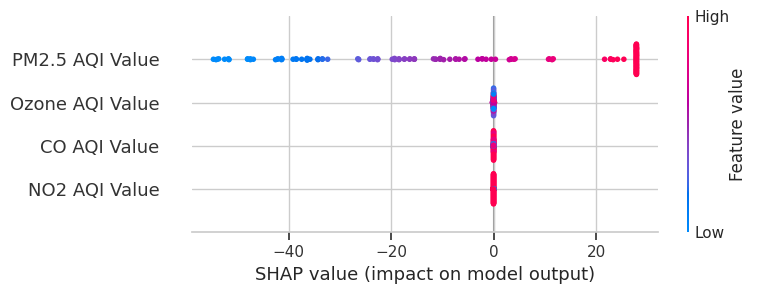

Feature Importances for Cluster 0:
 NO2 AQI Value      0.000024
CO AQI Value       0.000039
Ozone AQI Value    0.000219
PM2.5 AQI Value    0.999718
dtype: float64


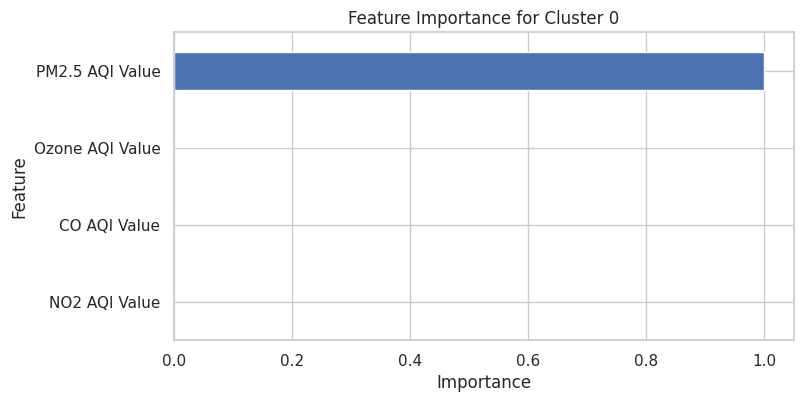

In [ ]:
analyze_specific_cluster(0)

##6.2 Cluster 1

Cluster 1:
SHAP Summary Plot for Cluster 1:


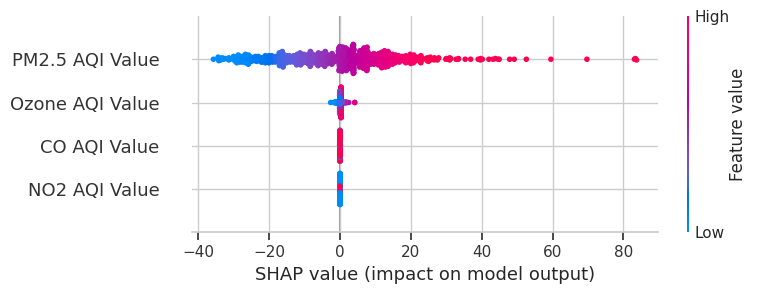

Feature Importances for Cluster 1:
 NO2 AQI Value      0.000009
CO AQI Value       0.000051
Ozone AQI Value    0.002811
PM2.5 AQI Value    0.997130
dtype: float64


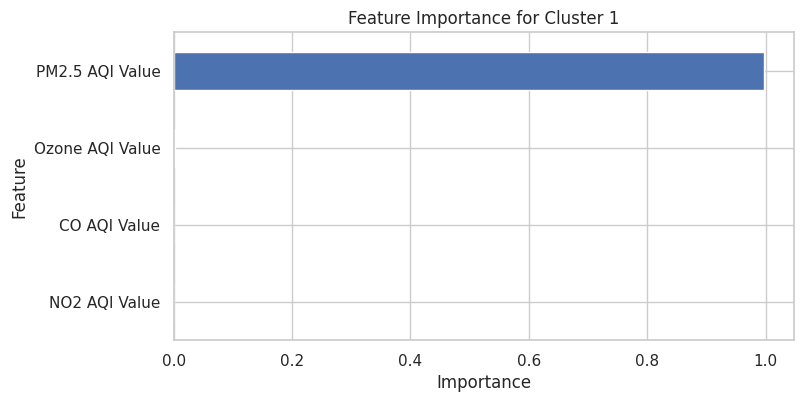

In [ ]:
analyze_specific_cluster(1)

##6.3 Cluster 2

Cluster 2:
SHAP Summary Plot for Cluster 2:


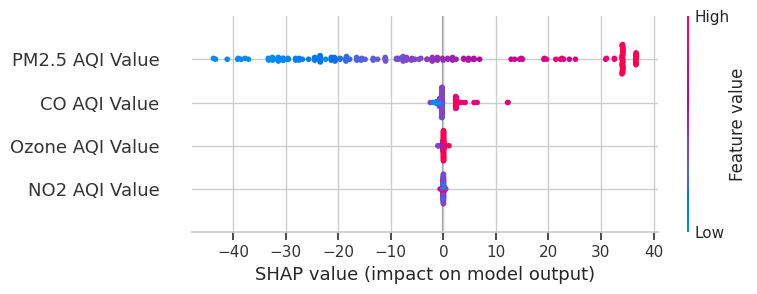

Feature Importances for Cluster 2:
 NO2 AQI Value      0.000362
Ozone AQI Value    0.000571
CO AQI Value       0.010188
PM2.5 AQI Value    0.988879
dtype: float64


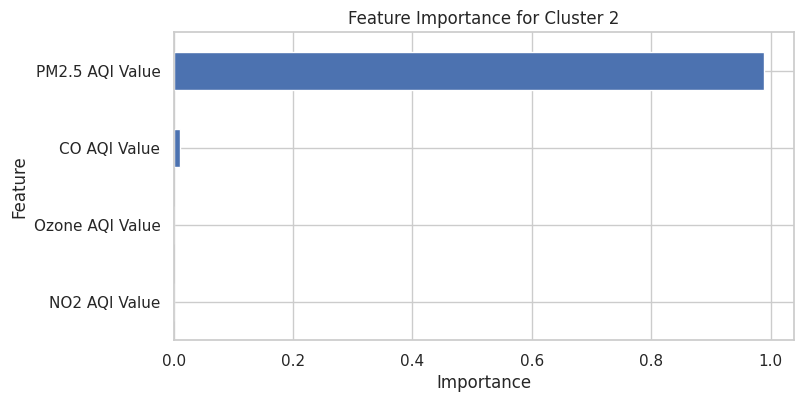

In [ ]:
analyze_specific_cluster(2)

#7.&nbsp;Visualization

Fisrt, i need to make sure each dataframe variabel is relevant to use

In [ ]:
df_result_kmeans.head()

Country       City  AQI Value  CO AQI Value  Ozone AQI Value  \
31    Indonesia  Pontianak       44.0           1.0             15.0   
55  Philippines    Dipolog       30.0           1.0             17.0   
66  Philippines     Guiset       66.0           1.0             26.0   
96    Indonesia     Tidore       21.0           0.0             13.0   
99  Philippines     Toboso       54.0           1.0             20.0   

    NO2 AQI Value  PM2.5 AQI Value   Latitude   Longitude  cluster  
31            0.0               44  -0.022690  109.344749        1  
55            0.0               30   8.586406  123.344937        1  
66            1.0               66  15.720875  120.777514        1  
96            0.0               21   0.678680  127.448316        1  
99            0.0               54  10.716947  123.513558        1

##7.1 Choropleth map cluster

In [ ]:
latitude_center = df_result_kmeans['Latitude'].mean()
longitude_center = df_result_kmeans['Longitude'].mean()

map_clusters = folium.Map(location=[latitude_center, longitude_center], zoom_start=5)

for i, row in df_result_kmeans.iterrows():
    if 90 >= row['Latitude'] >= -11 and 141 >= row['Longitude'] >= 95:
        if row['cluster'] == 0:
            icon = folium.Icon(icon='0', prefix='fa', color='red')
        elif row['cluster'] == 1:
            icon = folium.Icon(icon='1', prefix='fa', color='blue')
        elif row['cluster'] == 2:
            icon = folium.Icon(icon='2', prefix='fa', color='orange')
        else:
            icon = folium.Icon(icon='question', prefix='fa', color='gray')

        popup_text = f"""
        <b>City:</b> {row['City']}<br>
        <b>Cluster :</b> {row['cluster']}<br>
        <b>AQI Value:</b> {row['AQI Value']}<br>
        <b>CO Value :</b> {row['CO AQI Value']}<br>
        <b>Ozone Value :</b> {row['Ozone AQI Value']}<br>
        <b>NO2 Value :</b> {row['NO2 AQI Value']}<br>
        <b>PM2.5 Value :</b> {row['PM2.5 AQI Value']}
        """

        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            icon=icon,
            popup=popup_text
        ).add_to(map_clusters)

map_clusters

##7.2 Heatmap

In [ ]:
latitude_center = df_result_kmeans['Latitude'].mean()
longitude_center = df_result_kmeans['Longitude'].mean()

map_heatmap = folium.Map(location=[latitude_center, longitude_center], zoom_start=5)

# Data each featries
features = {
    'CO Value': df_result_kmeans[['Latitude', 'Longitude', 'CO AQI Value']],
    'Ozone Value': df_result_kmeans[['Latitude', 'Longitude', 'Ozone AQI Value']],
    'NO2 Value': df_result_kmeans[['Latitude', 'Longitude', 'NO2 AQI Value']],
    'PM2.5 Value': df_result_kmeans[['Latitude', 'Longitude', 'PM2.5 AQI Value']]
}

# Heatmap Layer
for feature_name, feature_data in features.items():
    heatmap_data = feature_data.values.tolist()
    feature_group = folium.FeatureGroup(name=feature_name, show=(feature_name == 'CO Value'))
    heatmap_layer = plugins.HeatMap(heatmap_data, radius=20)
    feature_group.add_child(heatmap_layer)
    map_heatmap.add_child(feature_group)

folium.LayerControl().add_to(map_heatmap)
map_heatmap


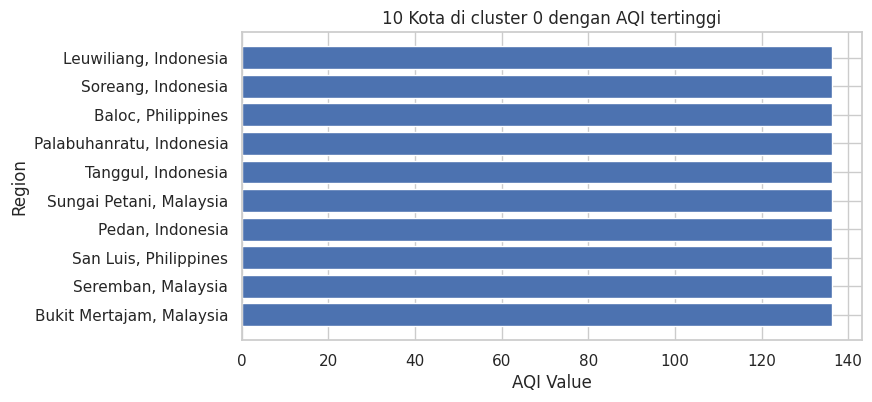

In [ ]:
# Top 10 Cities in Cluster 0 with Highest AQI Value
c0 = df_result_kmeans[df_result_kmeans['cluster'] == 0]
sorted_c0 = c0.sort_values(by='AQI Value', ascending=False)
top10_c0 = sorted_c0.head(10)

plt.figure(figsize=(8, 4))
plt.barh(top10_c0['City'] + ', ' + top10_c0['Country'], top10_c0['AQI Value'])
plt.xlabel('AQI Value')
plt.ylabel('Region')
plt.title('10 Kota di cluster 0 dengan AQI tertinggi')
plt.gca().invert_yaxis()
plt.show()

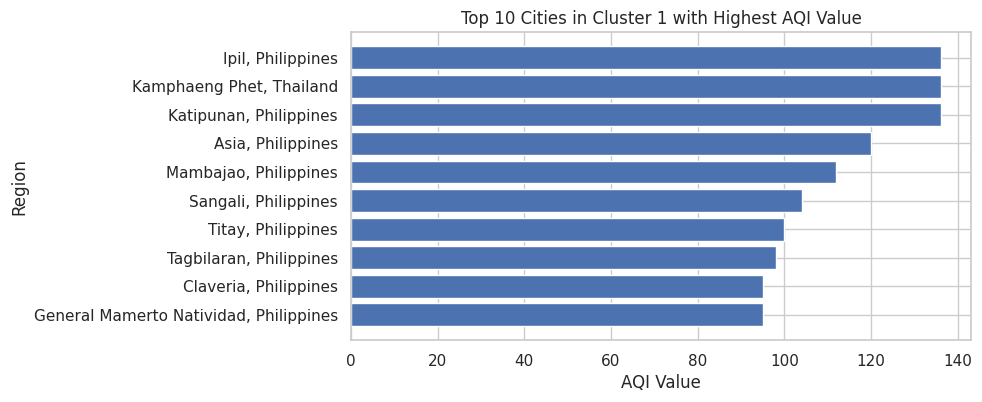

In [ ]:
# Top 10 Cities in Cluster 1 with Highest AQI Value
c1 = df_result_kmeans[df_result_kmeans['cluster'] == 1]
sorted_c1 = c1.sort_values(by='AQI Value', ascending=False)
top10_c1 = sorted_c1.head(10)

plt.figure(figsize=(8, 4))
plt.barh(top10_c1['City'] + ', ' + top10_c1['Country'], top10_c1['AQI Value'])
plt.xlabel('AQI Value')
plt.ylabel('Region')
plt.title('Top 10 Cities in Cluster 1 with Highest AQI Value')
plt.gca().invert_yaxis()
plt.show()

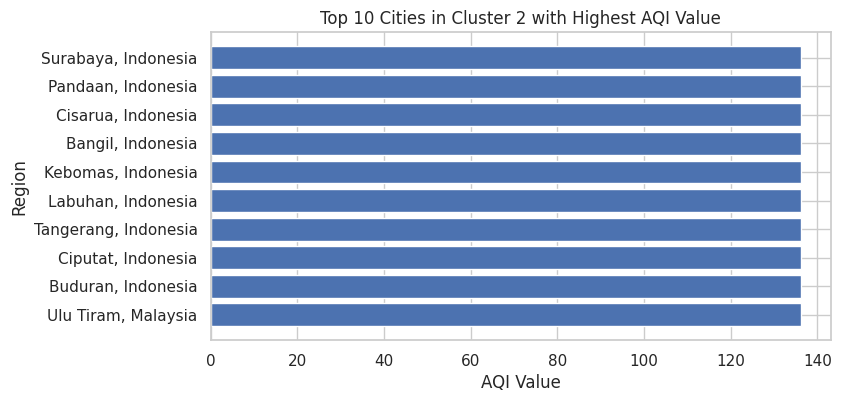

In [ ]:
# Top 10 Cities in Cluster 2 with Highest AQI Value
c2 = df_result_kmeans[df_result_kmeans['cluster'] == 2]
sorted_c2 = c2.sort_values(by='AQI Value', ascending=False)
top10_c2 = sorted_c2.head(10)

plt.figure(figsize=(8, 4))
plt.barh(top10_c2['City'] + ', ' + top10_c2['Country'], top10_c2['AQI Value'])
plt.xlabel('AQI Value')
plt.ylabel('Region')
plt.title('Top 10 Cities in Cluster 2 with Highest AQI Value')
plt.gca().invert_yaxis()
plt.show()

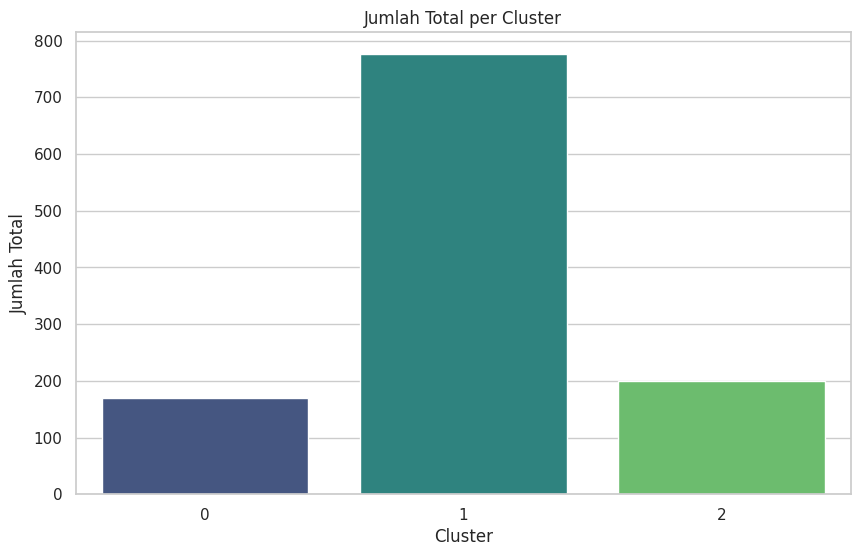

In [ ]:
# Total per Cluster
country_cluster = df_result_kmeans.groupby(['cluster', 'Country']).size().reset_index(name='Count')
total_per_cluster = country_cluster.groupby('cluster')['Count'].sum().reset_index(name='Total_Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='Total_Count', data=total_per_cluster, palette='viridis')
plt.title('Jumlah Total per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Total')
plt.show()

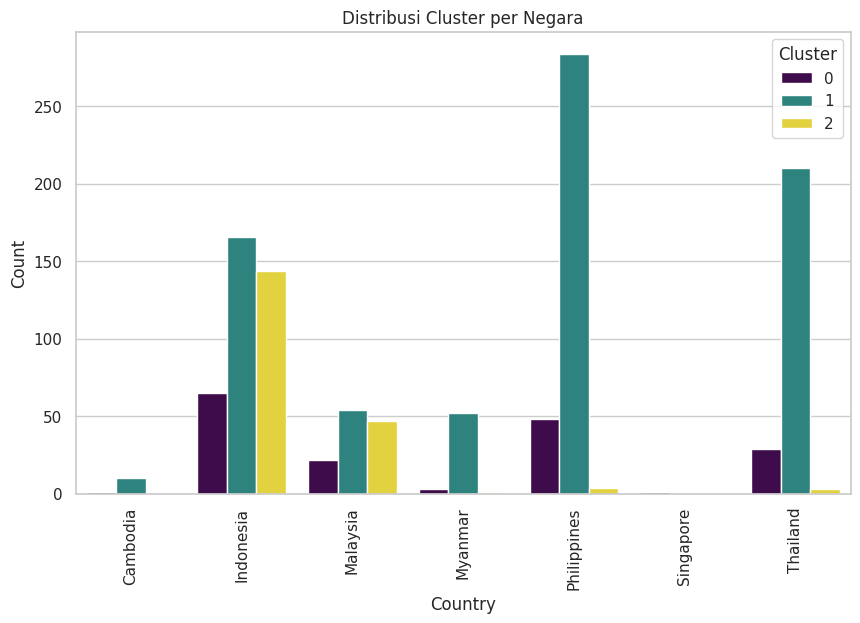

In [ ]:
country_cluster = df_result_kmeans.groupby(['cluster', 'Country']).size().reset_index(name='Count')
# country_cluster = country_cluster.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Count', hue='cluster', data=country_cluster, palette='viridis', dodge=True)
plt.title('Distribusi Cluster per Negara')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Cluster')
plt.show()

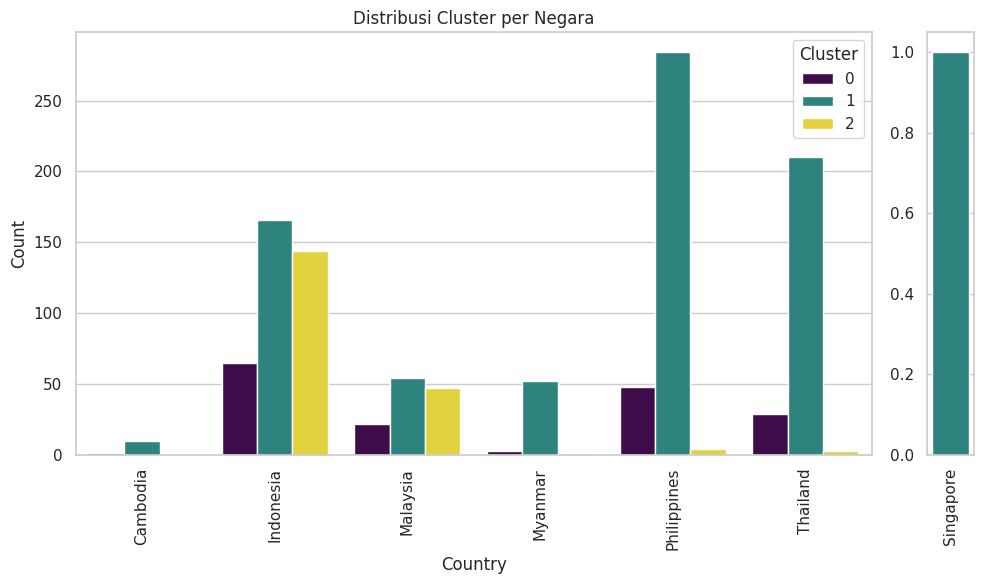

In [ ]:
singapore_data = country_cluster[country_cluster['Country'] == 'Singapore']
other_countries_data = country_cluster[country_cluster['Country'] != 'Singapore']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [17, 1]})

sns.barplot(x='Country', y='Count', hue='cluster', data=other_countries_data, palette='viridis', dodge=True, ax=ax1)
ax1.set_title('Distribusi Cluster per Negara')
ax1.set_xlabel('Country')
ax1.set_ylabel('Count')
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.legend(title='Cluster')

sns.barplot(x='Country', y='Count', data=singapore_data, palette='viridis', dodge=True, ax=ax2)
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel('')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

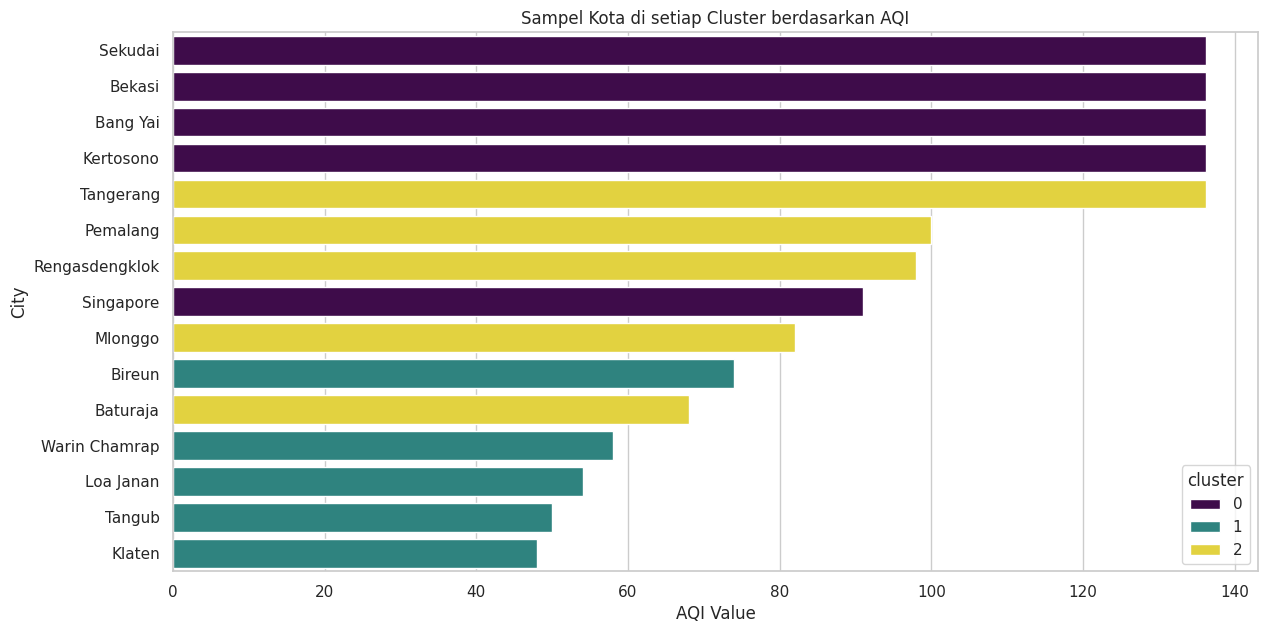

In [ ]:
sampled_df = df_result_kmeans.groupby('cluster').apply(lambda x: x.sample(n=5, random_state=42)).reset_index(drop=True)
sampled_df = sampled_df.sort_values(by='AQI Value', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x='AQI Value', y='City', hue='cluster', palette='viridis', data=sampled_df, dodge=False)
plt.title('Sampel Kota di setiap Cluster berdasarkan AQI')
plt.xlabel('AQI Value')
plt.ylabel('City')
plt.show()